# Описание

## Задачи
_Испольуется три задачи:_
- DM -- двухальтернативный выбор
- CtxDM -- DM с контекстом


## Сеть
 Сеть состоит из lif AdEx нейронов

## Проверяемый элемент
В данном файле тестируется обучение без случайного реконекта.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from cgtasknet.instruments.instrument_accuracy_network import CorrectAnswerNetwork
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    MultyReduceTasks,
)
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda:0


# Определяем датасет
Датасет будет состоять из трех типов задач:
- DM задача;
- CtxDM задача.
_Параметры для последней задачи аналогичны DM задаче_
***
## Параметры датасета:

In [3]:
batch_size = 32
number_of_epochs = 50
number_of_tasks = 1

go_task_list_values = np.linspace(0, 1, 8)

dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(trial_time=0.3, positive_shift_trial_time=1.0, answer_time=0.25)
)
ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm)

## Датасет

In [4]:
sigma = 0.5
tasks = [
    "DMTask1",
]
task_dict = {
    tasks[0]: dm_parameters,
}
Task = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
)

print("Task parameters:")
for key in task_dict:
    print(f"{key}:\n{task_dict[key]}\n")

print(f"inputs/outputs: {Task.feature_and_act_size[0]}/{Task.feature_and_act_size[1]}")

Task parameters:
DMTask1:
DMTaskRandomModParameters(dm=DMTaskParameters(dt=0.001, trial_time=0.3, answer_time=0.25, value=None, negative_shift_trial_time=0, positive_shift_trial_time=1.0), n_mods=2)

inputs/outputs: 4/3


In [5]:
sorted_tasks = sorted(tasks)
re_word = "Go"
choices_tasks = []
values_tasks = []
for i in range(len(sorted_tasks)):
    if re_word in sorted_tasks[i]:
        values_tasks.append(i)
    else:
        choices_tasks.append(i)
can = CorrectAnswerNetwork(choices_tasks, values_tasks, 0.15)

In [6]:
from cgtasknet.net import SNNLif
from norse.torch import LIFParameters

feature_size, output_size = Task.feature_and_act_size
hidden_size = 256

neuron_parameters = LIFParameters(
    v_th=torch.as_tensor(0.45),
    #tau_ada_inv=torch.as_tensor(1 / 2.0),
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNLif(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=20,
    save_states=True,
    return_spiking=True,
).to(device)
for name, param in model.named_parameters():
    if name == "alif.recurrent_weights":
        initial_parameters = torch.clone(param.detach().cpu())

In [8]:
Task.dataset(1)[0].shape

(1518, 32, 4)

## Критерий и функции ошибк

In [43]:
learning_rate = 5e-3
reg_freq = 1e4  # 1e3 for square #for 600 1e5


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


class MaskedMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, input, target, mask):
        diff2 = (torch.flatten(input) - torch.flatten(target)) ** 2.0 * torch.flatten(
            mask
        )
        result = torch.sum(diff2) / torch.sum(mask)
        return result


class MaskedAndFrRegMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedAndFrRegMSELoss, self).__init__()

    def forward(self, input, target, mask, state):
        diff2 = (torch.flatten(input) - torch.flatten(target)) ** 2.0 * torch.flatten(
            mask
        )
        result = torch.sum(diff2) / torch.sum(mask)
        s = []
        for i in range(len(state)):
            s.append(state[i])
        s = torch.stack(s)
        fr_neurons_mean = torch.mean(torch.mean(s, axis=0), axis=0)
        coefs = ((fr_neurons_mean > 0.03)).detach()
        fr_neurons_mean *= coefs
        fr_neurons_mean = torch.mean(fr_neurons_mean)
        result += fr_neurons_mean * reg_freq
        return result


criterion = MaskedAndFrRegMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
from numba import njit


@njit(cache=True, parallel=True)
def every_bath_generator(
    start_sigma: float,
    stop_sigma: float,
    times: int = 1,
    batches: int = 1,
    actions: int = 1,
):
    data = np.zeros((times, batches, actions))
    for i in range(batches):
        data[:, i, :] = np.random.normal(
            0, np.random.uniform(start_sigma, stop_sigma), size=(times, actions)
        )
    return data

In [45]:
torch.cuda.empty_cache()

In [46]:
from norse.torch import LIFState

Task_test = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
    task_number=0,
)


def check_mean_fr(task=Task):
    init_state = LIFState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
    inputs, target_outputs = task.dataset(1)

    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    result = model(
        inputs,
        init_state,
    )
    # del inputs, init_state
    torch.cuda.empty_cache()
    states = result[-1]
    spikes = []
    for state in states:
        spikes.append(state.detach().cpu())

    last_fix = torch.where(inputs[:, :, 0] == 1)[0][-1].item()
    # s = torch.stack(spikes)[:last_fix, ...]
    s = torch.stack(spikes)[:, ...]
    freq_sequence_new = torch.sort(
        torch.mean(torch.mean(s, axis=0), axis=0), dim=0
    ).values
    for i in range(len(freq_sequence_new)):
        plt.plot([i + 1] * 2, [0, freq_sequence_new[i] * 1e3], c="b")
    plt.show()
    plt.close()
    index = 0
    plt.plot(target_outputs[:, index, 0].detach().cpu(), c="r")
    plt.plot(target_outputs[:, index, 1].detach().cpu(), c="b")
    plt.plot(target_outputs[:, index, 2].detach().cpu(), c="g")

    plt.plot(result[0][:, index, 0].detach().cpu(), c="r", alpha=0.6)
    plt.plot(result[0][:, index, 1].detach().cpu(), c="b", alpha=0.6)
    plt.plot(result[0][:, index, 2].detach().cpu(), c="g", alpha=0.6)
    plt.show()
    plt.close()

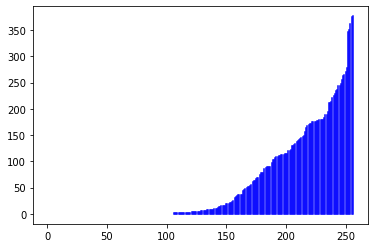

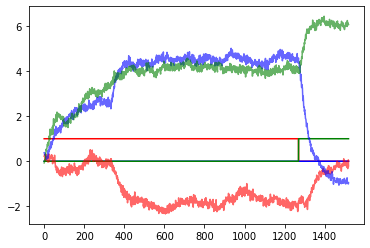

In [47]:
test = MultyReduceTasks(
    tasks=task_dict,
    batch_size=batch_size,
    delay_between=0,
    enable_fixation_delay=True,
    mode="random",
    task_number=0,
)
check_mean_fr(Task)

In [48]:
from tqdm import tqdm
from norse.torch import LIFState

path = "classic"
name = f"{path}/weights/weights_{neuron_parameters.alpha}_N_{hidden_size}_without_square_classic"
running_loss = 0
sigma = 0
for i in tqdm(range(number_of_epochs)):
    if i == 500:
        sigma = 0.2
    if i == 1000:
        sigma = 0.5
    inputs, target_outputs = Task.dataset(number_of_tasks)

    inputs[:, :, 1:3] += every_bath_generator(
        0, sigma, inputs.shape[0], inputs.shape[1], 2
    )
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    loss_mask = torch.zeros_like(target_outputs)
    mask_indexes_signes = torch.where(target_outputs[:, :, 0] == 1)
    mask_indexes_zeros = torch.where(target_outputs[:, :, 0] == 0)
    loss_mask[mask_indexes_signes[0], mask_indexes_signes[1], :] = 0.1
    loss_mask[mask_indexes_zeros[0], mask_indexes_zeros[1], :] = 1
    optimizer.zero_grad()
    init_state = LIFState(
        torch.zeros(batch_size, hidden_size).to(device),
        torch.rand(batch_size, hidden_size).to(device),
        torch.zeros(batch_size, hidden_size).to(device),
    )
    # forward + backward + optimize
    outputs, _, state = model(
        inputs,
        init_state,
    )

    loss = criterion(outputs, target_outputs, loss_mask, state)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss = loss.item()
    if True:
        with open(f"{path}/log_multy.txt", "a") as f:
            f.write("epoch: {:d} loss: {:0.5f}\n".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            torch.save(
                model.state_dict(),
                name + f"_{i}_",
            )
    if True:

        result = 0
        for j in range(20):
            try:
                del inputs
            except:
                pass
            try:
                del target_outputs
            except:
                pass
            try:
                del outputs
            except:
                pass
            torch.cuda.empty_cache()
            inputs, target_outputs = Task.dataset(1, delay_between=0)
            inputs[:, :, 1:3] += every_bath_generator(
                0, 0.01, inputs.shape[0], inputs.shape[1], 2
            )
            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs = model(
                inputs,
                init_state,
            )[0]
            type_tasks = list(
                np.where(inputs[-1, :, 3:].detach().cpu().numpy() == 1)[1]
            )
            answers = can.run(
                target_outputs[50:, :, 0].cpu(),
                outputs[50:, :, 0].cpu(),
                target_outputs[50:, :, 1:].cpu(),
                outputs[50:, :, 1:].cpu(),
                type_tasks,
            )
            result += answers

        accuracy = result / batch_size / 20 * 100
        with open(f"{path}/accuracy_multy_classic.txt", "a") as f:
            f.write(f"ecpoch = {i}; correct/all = {accuracy}\n")
    try:
        del inputs
    except:
        pass
    try:
        del target_outputs
    except:
        pass
    try:
        del outputs
        # del states
    except:
        pass
    # if i % 5 == 4:
    # check_mean_fr()
    torch.cuda.empty_cache()
print("Finished Training")

100%|██████████| 50/50 [15:01<00:00, 18.03s/it]

Finished Training
